In [218]:
import numpy as np
import matplotlib.pyplot as plt
import pymatching
from pymatching import Matching
import networkx as nx
from ldpc.codes import ring_code, rep_code
from ldpc.code_util import *
from ldpc.mod2 import *
from bposd.css import css_code
from bposd.css_decode_sim import css_decode_sim
from bposd.hgp import hgp
from bposd.stab import stab_code, gf2_to_gf4
from bposd import bposd_decoder
from ldpc.code_util import compute_code_distance

In [60]:
L = 3
ring = ring_code(L)
toric_code = hgp(ring, ring, compute_distance=True)
toric_code.test()

<Unnamed CSS code>, (2,4)-[[18,2,3]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (2,4)-[[18,2,3]]


True

In [13]:
#Here I try to reproduce the toric code in the paper
hx = ring_code(3)
hz = ring_code(2)
toric_code_2 = hgp(hx, hz, compute_distance=True)
toric_code_2.test()

<Unnamed CSS code>, (2,4)-[[12,2,2]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (2,4)-[[12,2,2]]


True

In [69]:
toric_code_2.lx #The logical X operator

array([[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0]])

In [70]:
toric_code_2.lz #The logical Z operator

array([[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]])

In [71]:
print(np.where(toric_code_2.lx[0]==1)) #The logical X qubits -- the X applying on the two canonical loops
print(np.where(toric_code_2.lx[1]==1)) #Note that the counting starts at 0, see the figure 2 in Bias-Tailored
#The logical X1 is at (5,6) and X2 is at (7,9,11)

(array([4, 5]),)
(array([ 6,  8, 10]),)


In [72]:
print(np.where(toric_code_2.lz[0]==1)) #The logical Z qubits -- the Z applying on the two canonical loops
print(np.where(toric_code_2.lz[1]==1))
#The logical Z1 is at (2,4,6) and X2 is at (7,8)

(array([1, 3, 5]),)
(array([6, 7]),)


In [84]:
toric_code_2.hx #This is the same as H1 otimes In2 combining with Im1 otimes H2T

array([[1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]])

In [85]:
print(np.kron(hx,np.identity(np.shape(hz)[1],dtype=int)))

[[1 0 1 0 0 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 0 0 1 0 1]
 [1 0 0 0 1 0]
 [0 1 0 0 0 1]]


In [87]:
print(np.where(toric_code_2.hx[0]==1))

(array([0, 2, 6, 7]),)


In [102]:
#This tells us the adjacency matrix of the X checks
adj_matrix_X = (np.dot(toric_code_2.hx, toric_code_2.hx.T) > 0).astype(int) #Here we transform the logical 0,1 to int 0,1
np.fill_diagonal(adj_matrix_X, 0)

In [103]:
adj_matrix_X

array([[0, 1, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0]])

In [104]:
#We can compare the adjacency matrix of X checks and the matching graph, they are the same
#The errors happen on the edges
match_x = pymatching.Matching(toric_code_2.hx)
match_x.edges()

[(0, 4, {'fault_ids': {0}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 5, {'fault_ids': {1}, 'weight': 1.0, 'error_probability': -1.0}),
 (0, 2, {'fault_ids': {2}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 3, {'fault_ids': {3}, 'weight': 1.0, 'error_probability': -1.0}),
 (2, 4, {'fault_ids': {4}, 'weight': 1.0, 'error_probability': -1.0}),
 (3, 5, {'fault_ids': {5}, 'weight': 1.0, 'error_probability': -1.0}),
 (0, 1, {'fault_ids': {6}, 'weight': 1.0, 'error_probability': -1.0}),
 (2, 3, {'fault_ids': {8}, 'weight': 1.0, 'error_probability': -1.0}),
 (4, 5, {'fault_ids': {10}, 'weight': 1.0, 'error_probability': -1.0})]

In [105]:
#This tells us the adjacency matrix of the Z checks
adj_matrix_Z = (np.dot(toric_code_2.hz, toric_code_2.hz.T) > 0).astype(int) #Here we transform the logical 0,1 to int 0,1
np.fill_diagonal(adj_matrix_Z, 0)
adj_matrix_Z

array([[0, 1, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 1, 0],
       [0, 1, 1, 0, 0, 1],
       [1, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 0]])

In [108]:
match_z = pymatching.Matching(toric_code_2.hz)
match_z.edges()

[(0, 1, {'fault_ids': {0}, 'weight': 1.0, 'error_probability': -1.0}),
 (2, 3, {'fault_ids': {2}, 'weight': 1.0, 'error_probability': -1.0}),
 (4, 5, {'fault_ids': {4}, 'weight': 1.0, 'error_probability': -1.0}),
 (0, 2, {'fault_ids': {6}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 3, {'fault_ids': {7}, 'weight': 1.0, 'error_probability': -1.0}),
 (2, 4, {'fault_ids': {8}, 'weight': 1.0, 'error_probability': -1.0}),
 (3, 5, {'fault_ids': {9}, 'weight': 1.0, 'error_probability': -1.0}),
 (0, 4, {'fault_ids': {10}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 5, {'fault_ids': {11}, 'weight': 1.0, 'error_probability': -1.0})]

In [109]:
GX = match_x.to_networkx()
GZ = match_z.to_networkx()

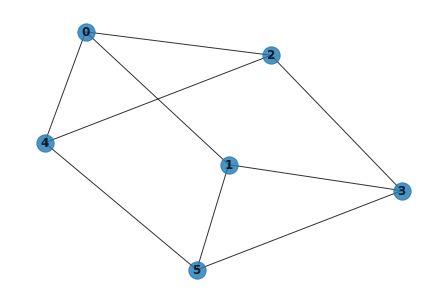

In [143]:
# The following code draw the X checks network and also the logical X1 and X2 operators
nx.draw(GX,pos=nx.spring_layout(GX,seed=1),width=1.0, alpha=0.8, with_labels=True, font_weight='bold')
# Here we know that each check only check three qubits, which is not good for a toric code, so we move

In [144]:
L = 3
ring = ring_code(L)
toric_code = hgp(ring, ring, compute_distance=True)
toric_code.test()

<Unnamed CSS code>, (2,4)-[[18,2,3]]
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params (2,4)-[[18,2,3]]


True

In [145]:
toric_code.lx #The logical X operator

array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]])

In [146]:
toric_code.lz #The logical Z operator

array([[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]])

In [147]:
#We can compare the adjacency matrix of X checks and the matching graph, they are the same
#The errors happen on the edges
match_x = pymatching.Matching(toric_code.hx)
match_x.edges()

[(0, 6, {'fault_ids': {0}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 7, {'fault_ids': {1}, 'weight': 1.0, 'error_probability': -1.0}),
 (2, 8, {'fault_ids': {2}, 'weight': 1.0, 'error_probability': -1.0}),
 (0, 3, {'fault_ids': {3}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 4, {'fault_ids': {4}, 'weight': 1.0, 'error_probability': -1.0}),
 (2, 5, {'fault_ids': {5}, 'weight': 1.0, 'error_probability': -1.0}),
 (3, 6, {'fault_ids': {6}, 'weight': 1.0, 'error_probability': -1.0}),
 (4, 7, {'fault_ids': {7}, 'weight': 1.0, 'error_probability': -1.0}),
 (5, 8, {'fault_ids': {8}, 'weight': 1.0, 'error_probability': -1.0}),
 (0, 1, {'fault_ids': {9}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 2, {'fault_ids': {10}, 'weight': 1.0, 'error_probability': -1.0}),
 (0, 2, {'fault_ids': {11}, 'weight': 1.0, 'error_probability': -1.0}),
 (3, 4, {'fault_ids': {12}, 'weight': 1.0, 'error_probability': -1.0}),
 (4, 5, {'fault_ids': {13}, 'weight': 1.0, 'error_probability': -1.0}),
 (

In [148]:
match_z = pymatching.Matching(toric_code.hz)
match_z.edges()

[(0, 2, {'fault_ids': {0}, 'weight': 1.0, 'error_probability': -1.0}),
 (0, 1, {'fault_ids': {1}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 2, {'fault_ids': {2}, 'weight': 1.0, 'error_probability': -1.0}),
 (3, 5, {'fault_ids': {3}, 'weight': 1.0, 'error_probability': -1.0}),
 (3, 4, {'fault_ids': {4}, 'weight': 1.0, 'error_probability': -1.0}),
 (4, 5, {'fault_ids': {5}, 'weight': 1.0, 'error_probability': -1.0}),
 (6, 8, {'fault_ids': {6}, 'weight': 1.0, 'error_probability': -1.0}),
 (6, 7, {'fault_ids': {7}, 'weight': 1.0, 'error_probability': -1.0}),
 (7, 8, {'fault_ids': {8}, 'weight': 1.0, 'error_probability': -1.0}),
 (0, 3, {'fault_ids': {9}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 4, {'fault_ids': {10}, 'weight': 1.0, 'error_probability': -1.0}),
 (2, 5, {'fault_ids': {11}, 'weight': 1.0, 'error_probability': -1.0}),
 (3, 6, {'fault_ids': {12}, 'weight': 1.0, 'error_probability': -1.0}),
 (4, 7, {'fault_ids': {13}, 'weight': 1.0, 'error_probability': -1.0}),
 (

In [156]:
match_x.edges()[0][2]

{'fault_ids': {0}, 'weight': 1.0, 'error_probability': -1.0}

In [149]:
GX = match_x.to_networkx()
GZ = match_z.to_networkx()

In [157]:
# The logical X1 operator
edgelist_X1 = []
for ind in np.where(toric_code.lx[0]==1)[0]:
    edgelist_X1.append((match_x.edges()[ind][0],match_x.edges()[ind][1]))
# The logical X2 operator
edgelist_X2 = []
for ind in np.where(toric_code.lx[1]==1)[0]:
    edgelist_X2.append((match_x.edges()[ind][0],match_x.edges()[ind][1]))

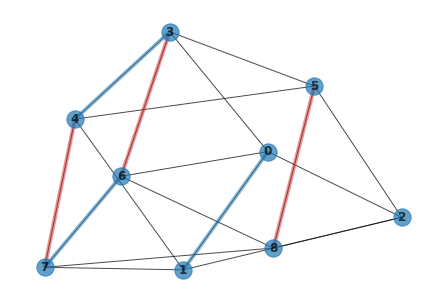

In [165]:
# The following code draw the X checks network and also the logical X1 and X2 operators
nx.draw(GX,pos=nx.spring_layout(GX,seed=1),width=1.0, alpha=0.7, with_labels=True, font_weight='bold')
nx.draw_networkx_edges(GX,pos=nx.spring_layout(GX,seed=1),edgelist=edgelist_X1,width=4.0,alpha=0.5,edge_color="tab:red")
nx.draw_networkx_edges(GX,pos=nx.spring_layout(GX,seed=1),edgelist=edgelist_X2,width=4.0,alpha=0.5,edge_color="tab:blue")

In [166]:
# The logical Z1 operator
edgelist_Z1 = []
for ind in np.where(toric_code.lz[0]==1)[0]:
    edgelist_Z1.append((match_z.edges()[ind][0],match_z.edges()[ind][1]))
# The logical Z2 operator
edgelist_Z2 = []
for ind in np.where(toric_code.lz[1]==1)[0]:
    edgelist_Z2.append((match_z.edges()[ind][0],match_z.edges()[ind][1]))

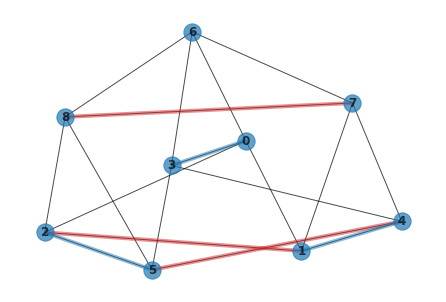

In [167]:
# The following code draw the Z checks network and also the logical Z1 and Z2 operators
nx.draw(GZ,pos=nx.spring_layout(GZ,seed=1),width=1.0, alpha=0.7, with_labels=True, font_weight='bold')
nx.draw_networkx_edges(GZ,pos=nx.spring_layout(GZ,seed=1),edgelist=edgelist_Z1,width=4.0,alpha=0.5,edge_color="tab:red")
nx.draw_networkx_edges(GZ,pos=nx.spring_layout(GZ,seed=1),edgelist=edgelist_Z2,width=4.0,alpha=0.5,edge_color="tab:blue")

In [230]:
# Now we try to understand the toric code example given by PyMatching
# import numpy as np
# import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag


def repetition_code(n):
    """
    Parity check matrix of a repetition code with length n.
    """
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1)%n)))
    data = np.ones(2*n, dtype=np.uint8)
    return csc_matrix((data, (row_ind, col_ind)))


def toric_code_x_stabilisers(L):
    """
    Sparse check matrix for the X stabilisers of a toric code with
    lattice size L, constructed as the hypergraph product of
    two repetition codes.
    """
    Hr = repetition_code(L)
    H = hstack(
            [kron(Hr, eye(Hr.shape[1])), kron(eye(Hr.shape[0]), Hr.T)],
            dtype=np.uint8
        )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)

def toric_code_x_logicals(L):
    """
    Sparse binary matrix with each row corresponding to an X logical operator
    of a toric code with lattice size L. Constructed from the
    homology groups of the repetition codes using the Kunneth
    theorem.
    """
    H1 = csc_matrix(([1], ([0],[0])), shape=(1,L), dtype=np.uint8)
    H0 = csc_matrix(np.ones((1, L), dtype=np.uint8))
    x_logicals = block_diag([kron(H1, H0), kron(H0, H1)])
    x_logicals.data = x_logicals.data % 2
    x_logicals.eliminate_zeros()
    return csc_matrix(x_logicals)

#Here, the weights being the LLR is because we hope to tell the MWPM algorithm that whether it should
#keep the shorter path or the longer path. When p is small, log(1-p/p)>0, the error happens with small
#probability and the shorter path it good. when p is large, the case is opposite, so it should keep the 
#longer path

#The prediction gives the predicted Z operators (to correct the error), and the logicals@prediction evaluates 
#the overlaps between the logical X's and the predicted Z operators. If a failure happens, the predicted Z
#differs the true Z by some logical Z (crossing logical X's), so we will get different result compared to logicals@noise.

def num_decoding_failures_via_physical_frame_changes(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-error_probability)/error_probability))
    num_errors = 0
    for i in range(num_shots):
        noise = (np.random.random(H.shape[1]) < error_probability).astype(np.uint8)
        syndrome = H@noise % 2
        prediction = matching.decode(syndrome)
        predicted_logicals_flipped = logicals@prediction % 2
        actual_logicals_flipped = logicals@noise % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors

def num_decoding_failures(H, logicals, p, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-p)/p), faults_matrix=logicals)
    num_errors = 0
    for i in range(num_shots):
        noise = (np.random.random(H.shape[1]) < p).astype(np.uint8)
        syndrome = H@noise % 2
        predicted_logicals_flipped = matching.decode(syndrome)
        actual_logicals_flipped = logicals@noise % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors

def num_decoding_failures_vectorised(H, logicals, error_probability, num_shots):
    matching = Matching.from_check_matrix(H, weights=np.log((1-p)/p), faults_matrix=logicals)
    noise = (np.random.random((num_shots, H.shape[1])) < error_probability).astype(np.uint8)
    shots = (noise @ H.T) % 2
    actual_observables = (noise @ logicals.T) % 2
    predicted_observables = matching.decode_batch(shots)
    num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))
    return num_errors

In [231]:
#Here we do some basic check, for example the repetition code is the same by the two methods
print(repetition_code(3).toarray())

[[1 1 0]
 [0 1 1]
 [1 0 1]]


In [232]:
#The HX from hypergraph product, which is the same as the construction before
#print(toric_code_x_stabilisers(3).toarray())
print(toric_code.hx)

[[1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0]
 [1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0]
 [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1]]


In [233]:
toric_code_x_logicals(3).toarray()

array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]],
      dtype=uint8)

In [234]:
toric_code.lx

array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]])

In [235]:
# We can see these two definitions are indeed homologically equivalent as we can see
(toric_code.hx[6]+toric_code.hx[7]+toric_code.hx[8]+toric_code.lx[0])%2

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We consider the example of toric code MWPM in https://pymatching.readthedocs.io/en/stable/toric-code-example.html

In [236]:
%%time

num_shots = 5000
Ls = range(4,14,4)
ps = np.linspace(0.01, 0.2, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    Hx = toric_code_x_stabilisers(L)
    logX = toric_code_x_logicals(L)
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, p, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...
CPU times: user 1.57 s, sys: 8.04 ms, total: 1.58 s
Wall time: 1.58 s


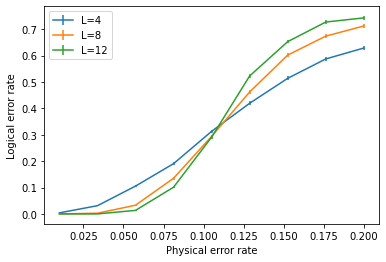

In [237]:
%matplotlib inline

plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

We will see the ldpc methods give the same result as pymatching

In [238]:
%%time

num_shots = 5000
Ls = range(4,14,4)
ps = np.linspace(0.01, 0.2, 9)
np.random.seed(2)
log_errors_all_L = []
for L in Ls:
    print("Simulating L={}...".format(L))
    toric_code_temp = hgp(ring_code(L), ring_code(L), compute_distance=True)
    Hx = toric_code_temp.hx
    logX = toric_code_temp.lx
    log_errors = []
    for p in ps:
        num_errors = num_decoding_failures_vectorised(Hx, logX, p, num_shots)
        log_errors.append(num_errors/num_shots)
    log_errors_all_L.append(np.array(log_errors))

Simulating L=4...
Simulating L=8...
Simulating L=12...
CPU times: user 2.69 s, sys: 13.3 ms, total: 2.71 s
Wall time: 2.7 s


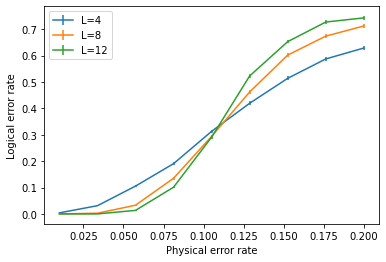

In [239]:
%matplotlib inline

plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(ps, logical_errors, yerr=std_err, label="L={}".format(L))
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);